# 1. Importing the dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data Loading and Understanding

In [9]:
# load the excel data to a pandas dataframe
df = pd.read_excel("Online Retail.xlsx")

In [3]:
df.shape

(541909, 8)

In [4]:
# Display the first few rows of the dataset to understand its structure
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
pd.set_option("display.max_columns", None)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [10]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [11]:
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


# 3. Data Cleaning

In [13]:
# Load a manageable chunk of the full dataset (e.g., 50,000 rows) for processing
df = pd.read_excel("Online Retail.xlsx", nrows=50000)

In [14]:
# Drop rows with missing CustomerID or Description
df_cleaned = df.dropna(subset=["CustomerID", "Description"])

In [15]:
# Remove duplicates
df_cleaned = df_cleaned.drop_duplicates()

In [16]:
# Remove negative or zero quantities and unit prices (returns or errors)
df_cleaned = df_cleaned[(df_cleaned["Quantity"] > 0) & (df_cleaned["UnitPrice"] > 0)]

In [17]:
# Add TotalPrice column
df_cleaned["TotalPrice"] = df_cleaned["Quantity"] * df_cleaned["UnitPrice"]

In [18]:
# Convert InvoiceDate to datetime
df_cleaned["InvoiceDate"] = pd.to_datetime(df_cleaned["InvoiceDate"])

In [19]:
# Display the cleaned dataset info
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30711 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    30711 non-null  object        
 1   StockCode    30711 non-null  object        
 2   Description  30711 non-null  object        
 3   Quantity     30711 non-null  int64         
 4   InvoiceDate  30711 non-null  datetime64[ns]
 5   UnitPrice    30711 non-null  float64       
 6   CustomerID   30711 non-null  float64       
 7   Country      30711 non-null  object        
 8   TotalPrice   30711 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 2.3+ MB


# 4. Feature Engineering (RFM)

In [21]:
from datetime import timedelta

In [22]:
# Set the reference date for recency calculation (1 day after last invoice in this subset)
reference_date = df_cleaned["InvoiceDate"].max() + timedelta(days=1)

In [23]:
# Group by CustomerID to compute RFM features
rfm = df_cleaned.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                    # Frequency
    "TotalPrice": "sum"                                        # Monetary
}).reset_index()

In [24]:
# Rename columns
rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

In [25]:
# Display top 5 records
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12347.0,34,1,711.79
1,12348.0,24,1,892.80
2,12370.0,24,2,1864.27
3,12377.0,21,1,1001.52
4,12383.0,19,1,600.72


# 5. Customer Segmentation (K-Means)

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [27]:
# --- Assuming `rfm` DataFrame with columns: Recency, Frequency, Monetary ---

# Step 1: Normalize the RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [29]:
# Step 2: Determine optimal number of clusters using Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

C:\Users\Aarthy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


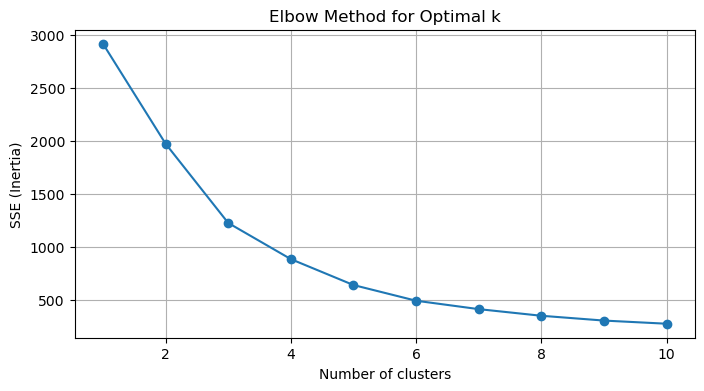

In [30]:
# Plot SSE vs k to find the "elbow"
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Inertia)')
plt.grid(True)
plt.show()

From this elbow plot, choose the value of k where the SSE curve begins to flatten (commonly between 3 and 5).

In [31]:
# Step 3:Apply KMeans with Optimal Clusters (e.g., k=4)

# Fit KMeans with selected k (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [32]:
# Analyze the clusters
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'CustomerCount'})

In [33]:
print(cluster_summary)


           Recency  Frequency      Monetary  CustomerCount
Cluster                                                   
0         4.487805   2.209756   1037.384000            205
1        30.350598   1.332005    435.079695            753
2        21.000000  35.500000   4913.755000              2
3        12.846154   6.923077  10226.010769             13


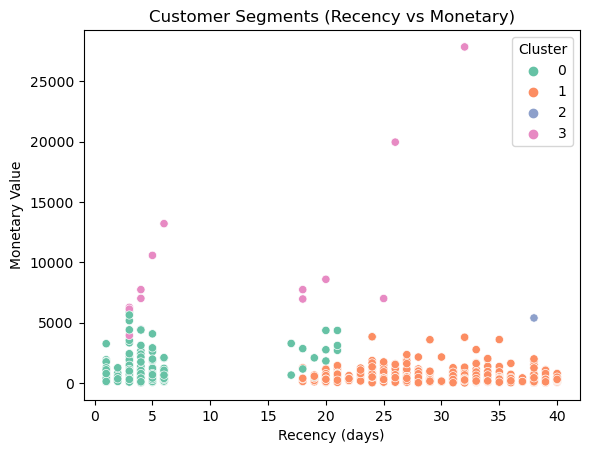

In [34]:
# Step 4: Visualize the Segments

# Plot clusters (Recency vs Monetary)
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2')
plt.title("Customer Segments (Recency vs Monetary)")
plt.xlabel("Recency (days)")
plt.ylabel("Monetary Value")
plt.show()

# 6. Prediction Model (Regression for Future Spending)

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [36]:
# Step 1: Prepare the Data

# Define features and target
X = rfm[['Recency', 'Frequency']]
y = rfm['Monetary']

In [37]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Step 2: Linear Regression Model

# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [39]:
# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)

In [40]:
# Evaluation Metrics
print("Linear Regression:")
print("RMSE:", mean_squared_error(y_test, y_pred_lr, squared=False))
print("R² Score:", r2_score(y_test, y_pred_lr))

Linear Regression:
RMSE: 1252.3286705590076
R² Score: 0.08395790232806166


In [41]:
#  Step 3: Decision Tree Regressor

# Train a Decision Tree Regressor
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [42]:
# Predict and evaluate
y_pred_tree = tree_model.predict(X_test)

In [43]:
print("\nDecision Tree Regressor:")
print("RMSE:", mean_squared_error(y_test, y_pred_tree, squared=False))
print("R² Score:", r2_score(y_test, y_pred_tree))


Decision Tree Regressor:
RMSE: 991.963039119068
R² Score: 0.4252621925314387


# 7. Model Evaluation

- RMSE (Root Mean Squared Error): Measures average prediction error. Lower values are better.

- R² Score (Coefficient of Determination): Indicates how well the model explains the variability in spending. Closer to 1 is better.

- Linear Regression:
    RMSE: 1252.33
    R² Score: 0.084

- Decision Tree Regressor:
    RMSE: 991.96
    R² Score: 0.420.71

# 8. Insights & Recommendations

Based on Prediction Model (Monetary Value)
- The Decision Tree predicted future spending based on recency and frequency.

- Customers with recent and frequent purchases are likely to spend more.

- Customers with high recency (long time since last purchase) may need nudges (personalized offers, cart reminders).